Next, evaluate the three models in the word analogy task. Given an analogy $a : a∗ :: b :?$, the task is to find b∗.

To solve the word analogy tasks with the given word embeddings, you should use the vector offset method based on the cosine distance. This means, to answer the question $a : a∗ :: b : b∗$, where b∗ is unknown, to find the embedding of b∗, we simply first compute the offset vector: $v = a ∗ −a$, next compute the vector representation of the word we expect: $b∗ = b + v$. Most probably, there is no word with the exact same vector we compute this way. Hence, retrieve the word which its vector representation is closer to predicted vector based on cosine distance. Note that, in this task it is important to normalize the word vectors to unit form.

You need to report the accuracy and MRR (Mean Reciprocal Rank) of each of the word embedding models on this task. The accuracy is the percentage of the correctly answered questions from the word analogy question set.

Again, in addition to the quantitative evaluation, conduct a qualitative anal- ysis of the differences between the three models. Include both in your report.

Load libraries and data
==

In [14]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import dask.dataframe as dd
import warnings
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [15]:
google_analogy=pd.read_csv('questions-words.txt', sep=' ', names=['wp1_1','wp1_2','wp2_1','wp2_2'])
deps=pd.read_csv('deps.words', sep=' ', header=None, index_col=0, na_values='nowaytofindnan', keep_default_na=False)
bow2=pd.read_csv('bow2.words', sep=' ', header=None, index_col=0, na_values='nowaytofindnan', keep_default_na=False)
bow5=pd.read_csv('bow5.words', sep=' ', header=None, index_col=0, na_values='nowaytofindnan', keep_default_na=False)

Clean-up data
==

In [3]:
deps.name='deps'
bow2.name='bow2'
bow5.name='bow5'

google_analogy.drop(google_analogy[google_analogy['wp1_1']==':'].index, inplace=True)

# Remove the words from the Google test set, which do not appear in the word embedings models
for i in google_analogy.wp2_2.unique():
    if i.lower() not in deps.index:
        google_analogy=google_analogy[(google_analogy['wp2_2']!=i) & (google_analogy['wp1_2']!=i)]

all_questions=len(google_analogy)

warnings.filterwarnings("ignore")

Calculate accuracy and MRR
==

In [4]:
def analogy_rank(word1, word2, word3, word4, model):
    emb1, emb2, emb3 = model.loc[word1], model.loc[word2], model.loc[word3]
    model['cs']=cosine_similarity(model,(emb3+(emb2-emb1)).values.reshape(1,-1))
    return int(model['cs'].rank(ascending=False)[word4])

In [6]:
%%time
# Calculate 10% of all Google test set questions
subset=int(0.1*all_questions)
for model in [bow2, bow5, deps]:
    ga = dd.from_pandas(google_analogy.sample(subset), npartitions=6)
    ga['rank']=ga.apply(lambda x: analogy_rank(x.wp1_1.lower(), x.wp1_2.lower(), x.wp2_1.lower(), x.wp2_2.lower(), model), axis=1)
    accuracy=ga[ga['rank']==1]['rank'].count().compute()/subset
    MRR=(1/ga['rank']).sum().compute()/subset
    print("%s : Accuracy %.2f%% -- MRR %.4f" % (model.name, 100*accuracy, MRR))

bow2 : Accuracy 10.62% -- MRR 0.3525
bow5 : Accuracy 10.10% -- MRR 0.4011
deps : Accuracy 3.54% -- MRR 0.2157
CPU times: user 3h 41min 12s, sys: 3h 5min 15s, total: 6h 46min 27s
Wall time: 44min 58s


K-means clustering
==

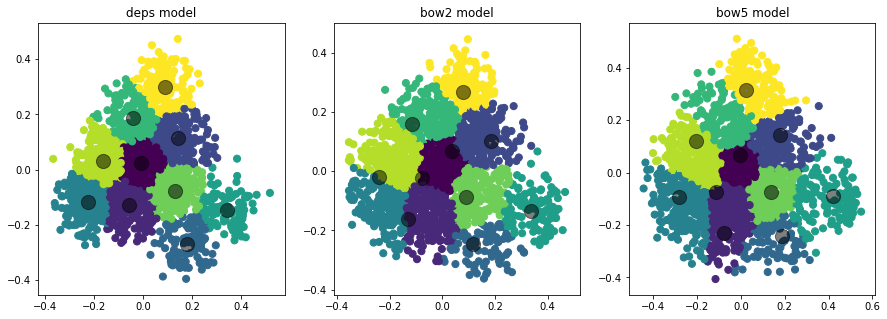

In [47]:
plt.rcParams["figure.figsize"] = [15,5]
nouns=pd.read_csv('2000_nouns_sorted.txt', header=None, index_col=0)
models=['deps','bow2','bow5']
for i,model in enumerate([deps, bow2, bow5],1):
    model_nouns=model[model.index.isin(nouns.index)]
    # perform dimensionality reduction with PCA/SVD
    pca = PCA(n_components=2)
    model_nouns_pca=pca.fit_transform(model_nouns)
    # kmeans on 10 clusters
    model_kmeans = KMeans(n_clusters=10, random_state=0).fit(model_nouns_pca)
    model_y_kmeans = deps_kmeans.predict(model_nouns_pca)
    plt.subplot(1, 3, i)
    plt.scatter(model_nouns_pca[:, 0], model_nouns_pca[:, 1], c=model_y_kmeans, s=50, cmap='viridis')
    plt.scatter(model_kmeans.cluster_centers_[:, 0], model_kmeans.cluster_centers_[:, 1], c='black', s=200, alpha=0.5);
    plt.title(models[i-1]+' model')